Yet to finalised

Consistency in variance (Add GARCH family or multiplier in terms of time)
QC on ACF and PACF
Bayesian MLE of MSAR
Research on changes in variance

Possible improvement
Diff, GARCH/Multiplier, Seasonality QC, Removal of sudden spike due to extreme/unexpected event
Prediction of extreme event... Next research? (Frequency severity model)

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

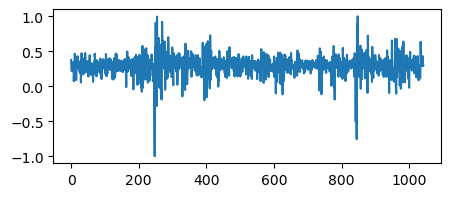

In [2]:
data = pd.read_csv('snp500.csv')['Close']

# Data Normalization (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Log-transform data
log_data = np.log(data)

# Differenced data
diff_data = data.diff().values[1:]

# Remove trend by mean/ Excess return
mean_data = data - np.mean(data)

# Log diff data
ld_data = np.log(data).diff().values[1:]

# Scaled log data
sl_data = scaler.fit_transform(log_data.values.reshape(-1, 1))



# Final: scaled_Log_Difference data yield the best result/performance
scaler = MinMaxScaler(feature_range=(-1, 1))

final_data = np.log(data).diff().values[1:]
final_data = scaler.fit_transform(ld_data.reshape(-1, 1))
final_data = pd.DataFrame(final_data)

plt.figure(figsize=(5,2))
plt.plot(final_data)


# for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(data):
#     x_train, x_test = data[train_idx], data[test_idx]
    # y_train, y_test = y[train_idx], y[test_idx] 

In [3]:
MSAR = sm.tsa.MarkovAutoregression(
    endog = final_data,
    k_regimes=2,
    order=1,
    switching_variance=True,
    trend='c'
)
# Maximum Likelihood Optimization failed when using trend=c (constant term)
Model = MSAR.fit(maxiter=5000)
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        0   No. Observations:                 1041
Model:             MarkovAutoregression   Log Likelihood                 658.795
Date:                  Mon, 30 Sep 2024   AIC                          -1301.589
Time:                          20:39:57   BIC                          -1262.006
Sample:                               0   HQIC                         -1286.574
                                 - 1041                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2473      0.016     15.578      0.000       0.216       0.278
sigma2         0.0685      0.008      8.546      0.000       0.053       0.084
ar.L1         -0.0833      0.065     -1.287      0.198      -0.210       0.044
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2959      0.003     88.112      0.000       0.289       0.302
sigma2         0.0087      0.001     12.606      0.000       0.007       0.010
ar.L1         -0.0993      0.039     -2.544      0.011      -0.176      -0.023
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9278      0.023     40.309      0.000       0.883       0.973
p[1->0]        0.0230      0.008      2.985      0.003       0.008       0.038
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

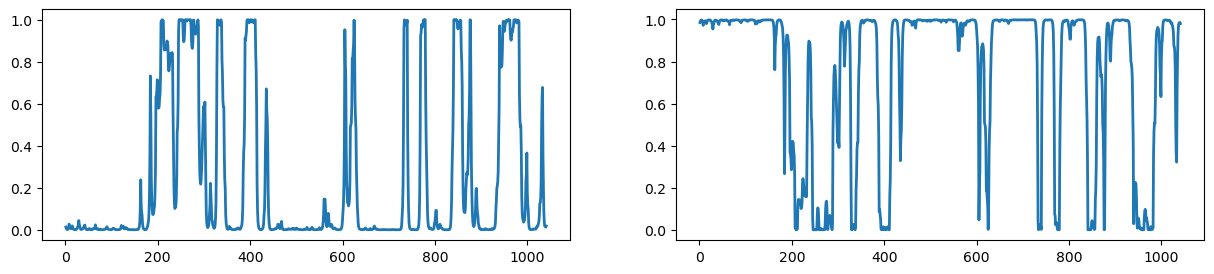

In [4]:
smoprob = Model.smoothed_marginal_probabilities
filprob = Model.filtered_marginal_probabilities # Not used
# print(smoprob.head())
# print(smoprob.shape)

fig, axes = plt.subplots(1,2, figsize=(15, 3))

axes[0].plot(smoprob[0], lw=2)
axes[1].plot(smoprob[1], lw=2)
# axes[2].plot(smoprob[2])

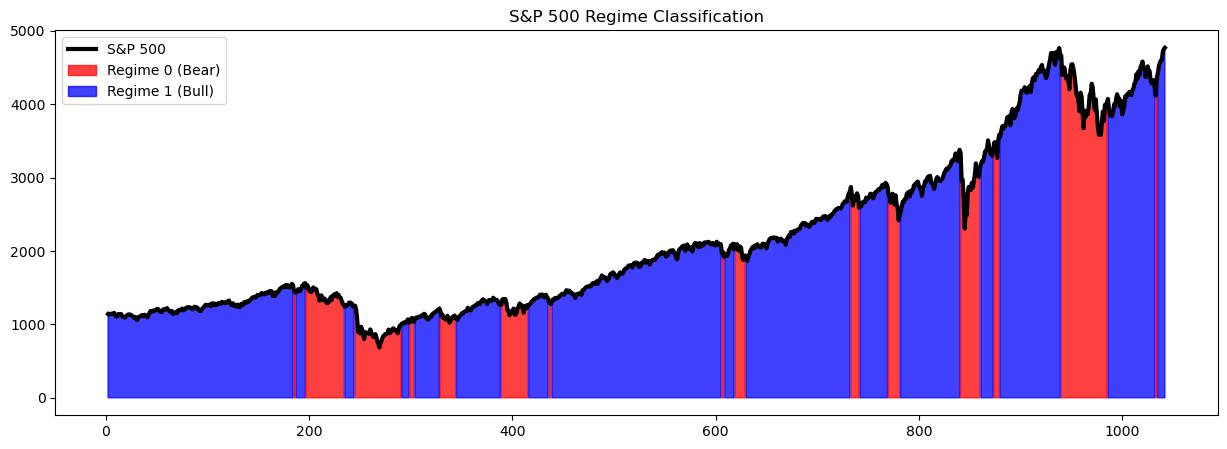

In [5]:
# Most likely regime at each time step based on smoothed probabilities
regime = np.argmax(smoprob, axis=1)

plt.figure(figsize=(15,5))
plt.plot(data.index[2:], data[2:], label='S&P 500', color='black', lw=3)

# Draw filled boxes under the region
plt.fill_between(data.index[2:], data[2:], where=(regime == 0), color='red', alpha=0.75, label='Regime 0 (Bear)')
plt.fill_between(data.index[2:], data[2:], where=(regime == 1), color='blue', alpha=0.75, label='Regime 1 (Bull)')
# plt.fill_between(data.index[2:], data[2:], where=(regimes == 2), color='red', alpha=0.5, label='Regime 2')


plt.title('S&P 500 Regime Classification')
plt.legend()

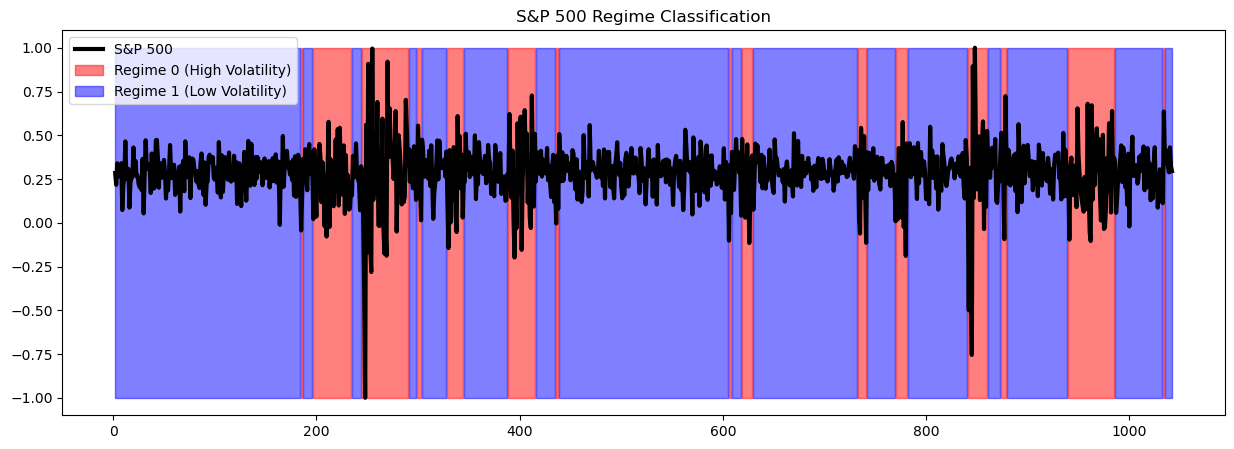

In [6]:
# Most likely regime at each time step based on smoothed probabilities
regime = np.argmax(smoprob, axis=1)
# print(final_data)

plt.figure(figsize=(15,5))
plt.plot(data.index[2:], final_data[0][1:], label='S&P 500', color='black', lw=3)

# Draw filled boxes under the region.
plt.fill_between(data.index[2:], -1,1, where=(regime == 0), color='red', alpha=0.5, label='Regime 0 (High Volatility)')
plt.fill_between(data.index[2:], -1,1, where=(regime == 1), color='blue', alpha=0.5, label='Regime 1 (Low Volatility)')
# plt.fill_between(data.index[2:], data[2:], where=(regimes == 2), color='red', alpha=0.5, label='Regime 2')


plt.title('S&P 500 Regime Classification')
plt.legend()

In [9]:
with open ('Regime.txt', 'w') as f:
    f.writelines(str(r) for r in regime)